# Business Insights & Model Verification

This notebook analyzes the final Marts models produced by dbt. 
It simulates how a Data Analyst or Business Stakeholder would consume the data we engineered.

## Key Metrics Analyzed:
1. **Funnel Conversion Rates**: Where are deals dropping off?
2. **Sales Rep Performance**: Who is driving the most value?
3. **Activity Volume**: Correlation between activities and deals.

In [4]:
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt

# Database Connection
DB_CONNECTION = "postgresql://admin:admin@db:5432/postgres"
engine = sqlalchemy.create_engine(DB_CONNECTION)

print("Connected to Data Marts!")

Connected to Data Marts!


## 1. Funnel Conversion Analysis

We will look at the `rep_sales_funnel_monthly` table to calculate step-to-step conversion rates.

/tmp/ipykernel_637/4224078912.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


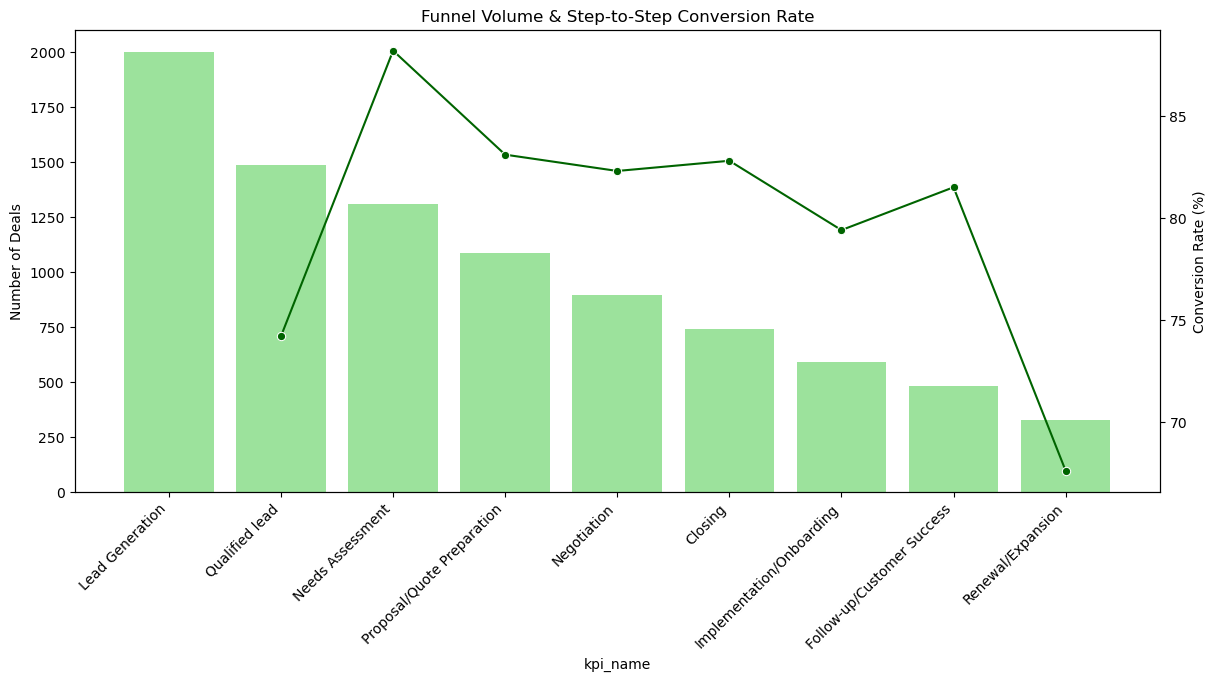

In [5]:
query = """
WITH funnel_agg AS (
    SELECT 
        funnel_step, 
        kpi_name,
        SUM(deals_count) as total_deals
    FROM public_marts.rep_sales_funnel_monthly
    WHERE funnel_step NOT IN ('Lost', '2.1', '3.1') -- Focus on main stages for conversion
    GROUP BY funnel_step, kpi_name
    ORDER BY funnel_step
)
SELECT 
    *,
    LAG(total_deals) OVER (ORDER BY funnel_step) as prev_step_count,
    ROUND(total_deals * 100.0 / NULLIF(LAG(total_deals) OVER (ORDER BY funnel_step), 0), 1) as conversion_rate
FROM funnel_agg;
"""

try:
    df_conv = pd.read_sql(query, engine)
    
    # Plotting
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_conv, x='kpi_name', y='total_deals', color='lightgreen')
    
    # Add secondary axis for conversion rate
    ax2 = ax.twinx()
    sns.lineplot(data=df_conv, x='kpi_name', y='conversion_rate', marker='o', color='darkgreen', ax=ax2)
    
    ax.set_title('Funnel Volume & Step-to-Step Conversion Rate')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Number of Deals')
    ax2.set_ylabel('Conversion Rate (%)')
    plt.show()
    
except Exception as e:
    print("Marts not built yet. Run 'dbt run' first.")
    print(e)

## 2. Sales Rep Performance Leaderboard

Using our reusable intermediate models, we built a second report `rep_sales_rep_performance_monthly`. Let's see who the top performers are and what activities they are focusing on.

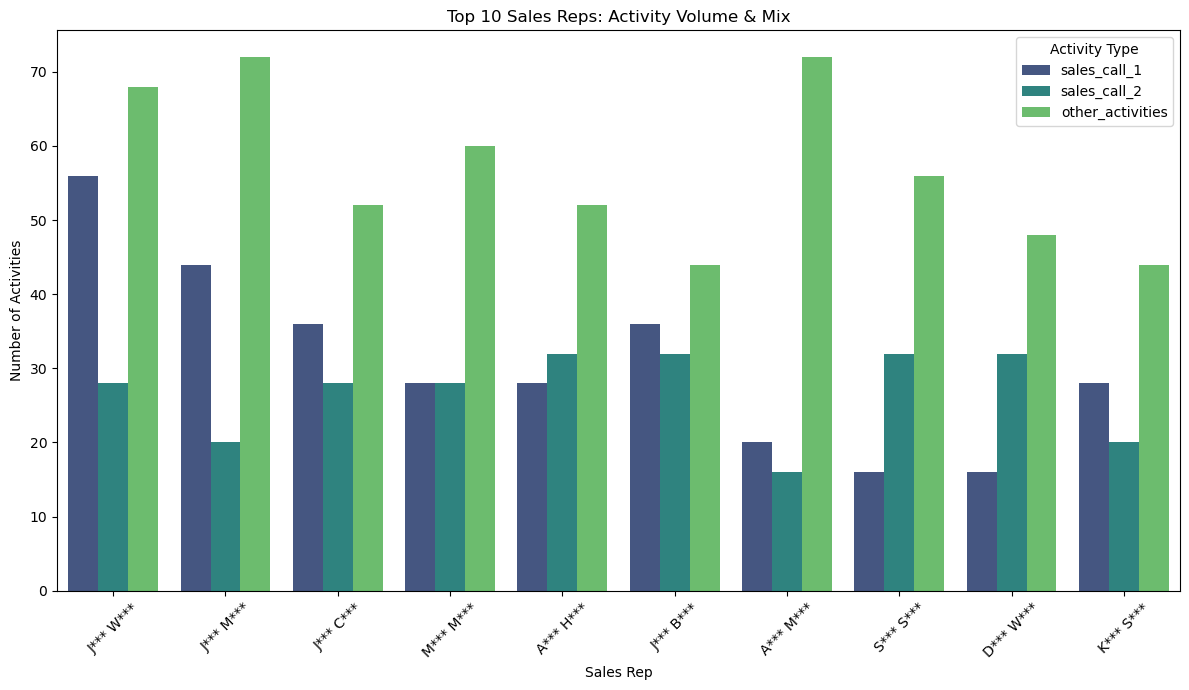

In [6]:
query_reps = """
SELECT 
    sales_rep_name,
    SUM(sales_call_1_completed) as sales_call_1,
    SUM(sales_call_2_completed) as sales_call_2,
    SUM(other_activities) as other_activities,
    SUM(activities_completed) as total_activities
FROM public_marts.rep_sales_rep_performance_monthly
GROUP BY sales_rep_name
ORDER BY total_activities DESC
LIMIT 10;
"""

df_reps = pd.read_sql(query_reps, engine)

# Reshape for stacked plot
df_melt = df_reps.melt(id_vars=['sales_rep_name', 'total_activities'], 
                       value_vars=['sales_call_1', 'sales_call_2', 'other_activities'], 
                       var_name='Activity Type', value_name='Count')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melt, x='sales_rep_name', y='Count', hue='Activity Type', palette='viridis')
plt.title('Top 10 Sales Reps: Activity Volume & Mix')
plt.xlabel('Sales Rep')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.legend(title='Activity Type')
plt.tight_layout()
plt.show()